Assignment 1 - analysis of movie reviews
===

*Due: November 29 2022*

In this assignment you will use web scraping tools to extract the reviews of 2 movies - Dune and Interstellar  - from Rotten Tomatoes.

You will save these reviews as text - strings - in a database that you will save as a CSV file.

After obtaining a dataset of Dune and Interstellar reviews, for each movie you will obtain:

- Wordclouds

- Word Frequency Barplots with the 20 most-frequent words: frequency as Y-axis and words as X-axis

- Sentiment scores for each movie using AFINN

## Define function to download reviews

In [40]:
import pandas as pd
import requests
import re
import time
import html
import regex as re
import json, os
import matplotlib.pyplot as plt
import contractions
from wordcloud import WordCloud
import nltk
from afinn import Afinn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords


data_path = "data/"


stop_words = set(stopwords.words("english"))

vader_sia = SentimentIntensityAnalyzer()
afinn = Afinn()


def download_reviews(url):
    """
    downloads all rotten tomatoes reviews for a movie
    """

    data_path = "data/"

    headers = {
        "Referer": "https://www.rottentomatoes.com/m/notebook/reviews?type=user",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest",
    }

    s = requests.Session()
    r = requests.get(url)
    movie_id = re.findall(r'(?<=movieId":")(.*)(?=","type)', r.text)[0]

    api_url = f"https://www.rottentomatoes.com/napi/movie/{movie_id}/reviews/user"  # use criticsReviews/all for critics reviews

    payload = {
        "direction": "next",
        "endCursor": "",
        "startCursor": "",
    }

    review_data = []

    while True:
        r = s.get(api_url, headers=headers, params=payload)
        data = r.json()

        # unescape html
        for i, review in enumerate(data["reviews"]):
            data["reviews"][i]["review"] = html.unescape(review["review"])

        if not data["pageInfo"]["hasNextPage"]:
            break

        payload["endCursor"] = data["pageInfo"]["endCursor"]
        payload["startCursor"] = (
            data["pageInfo"]["startCursor"]
            if data["pageInfo"].get("startCursor")
            else ""
        )

        review_data.extend(data["reviews"])
        time.sleep(1)

    if os.path.exists(data_path) == False:
        os.makedirs(data_path)

    df = pd.json_normalize(review_data)
    df = df.drop_duplicates()
    df.to_csv("{}{}.csv".format(data_path, movie), index=False)

    print(movie + ":", len(df), "reviews")

    return None


def plot_wordcloud(df, name="", max_words=20):
    """
    plots a figure with wordcloud
    """

    word_string = " ".join(list(df.review))
    word_string = word_string.lower()
    word_string = contractions.fix(word_string)
    word_string = re.sub(",|\.|--|!|\?|:|\"|\(|\)|\[|\]|\s-\s|/|'s|'", " ", word_string)

    wordcloud = WordCloud(
        collocations=False,
        max_font_size=100,
        width=800,
        height=600,
        colormap="Set2",
        max_words=max_words,
        background_color="white",
    ).generate(word_string)

    if name != "":
        name = "_" + name + "_"

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("wordcloud" + name + ".png")
    plt.show()


def create_wordstring(df):
    """
    returns a clean wordstring
    """

    # One long string
    word_string = " ".join(list(df.review))

    # To lower case
    # word_string = word_string.lower()

    # remove contractions
    word_string = contractions.fix(word_string)

    return word_string


def create_df_wordcount(df):
    """
    Returns dataframe with word count
    """

    word_string = create_wordstring(df)

    word_string = word_string.lower()

    # Replace dots, exclamation marks and so on ... with space
    word_string = re.sub(
        ",|\.|--|!|\?|:|\"|\(|\)|\[|\]|\s-\s|/|'s|'", " ", word_string
    )
    # Split into list of words
    word_list = word_string.split(" ")
   
    # create dataframe
    df_word_count = pd.DataFrame(word_list, columns=["word"])

   
    # remove stop words, empty strings, words shorter than 3 chars
    df_word_count = df_word_count.loc[
        (~df_word_count.word.isin(stop_words)) & (df_word_count.word != "") #& (df_word_count.word.str.len()>2)
    ].reset_index(drop=True)
   
    # add word count
    df_word_count["count"] = 0

    df_word_count = df_word_count.groupby("word").count().reset_index().sort_values(
        "count", ascending=False
    )
    

    return df_word_count

## Download reviews

In [41]:
movies = ["interstellar_2014", "dune_2021", "shining"]


for movie in movies:
    if os.path.exists(data_path + movie + ".csv"):
        print(movie, "loaded,", len(pd.read_csv(data_path + movie + ".csv")), "reviews")
    else:
        print("loading", movie, "...")
        download_reviews("https://www.rottentomatoes.com/m/" + movie + "/reviews")
        print(movie, "loaded,", len(pd.read_csv(data_path + movie + ".csv")), "reviews")

interstellar_2014 loaded, 12671 reviews
dune_2021 loaded, 8780 reviews
shining loaded, 28390 reviews


## Interstellar

<img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwallup.net%2Fwp-content%2Fuploads%2F2016%2F01%2F147474-space-Interstellar_movie-movies.jpg&f=1&nofb=1&ipt=bd3fc233f0b8f58f60cf470d36c4033063db92dc8f044c9a6dd682d133f0cdcb&ipo=images" style="width:800px">

### Word clouds

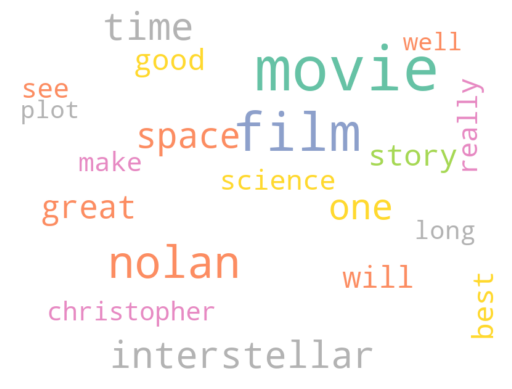

In [42]:
name = "interstellar_2014"

interstellar = pd.read_csv(data_path + name + ".csv")
plot_wordcloud(interstellar, name)

### Plot word frequency

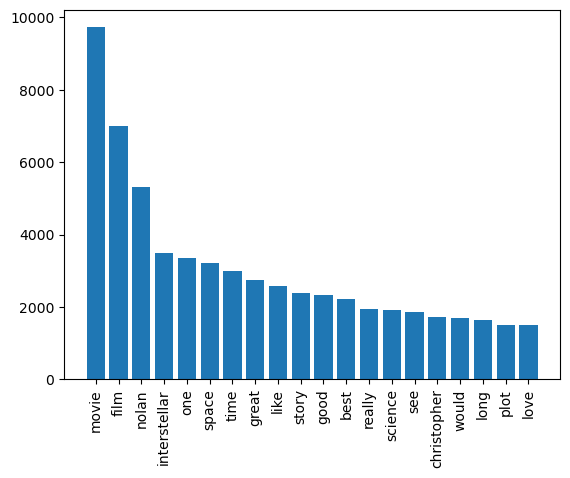

In [45]:
df_word_count = create_df_wordcount(interstellar)

# limit to the 20 most frequent words
df_pl = df_word_count.iloc[0:20, :]

plt.bar(x=df_pl["word"], height=df_pl["count"])
plt.xticks(rotation=90);

### Sentiment score

In [46]:
text = create_wordstring(interstellar)

print("AFINN:\t", afinn.score(text))
print("vader:\t", vader_sia.polarity_scores(text)["compound"])

AFINN:	 72237.0
vader:	 1.0


## Dune

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi0.wp.com%2Fnerdmuch.com%2Fwp-content%2Fuploads%2F2019%2F07%2Fdune-movie.jpg&f=1&nofb=1&ipt=9aca5a0f374877be1b804400befe5665f7e3dea66a3e0327f993b70573d47ece&ipo=images" style="width:800px;"/>

### Word clouds

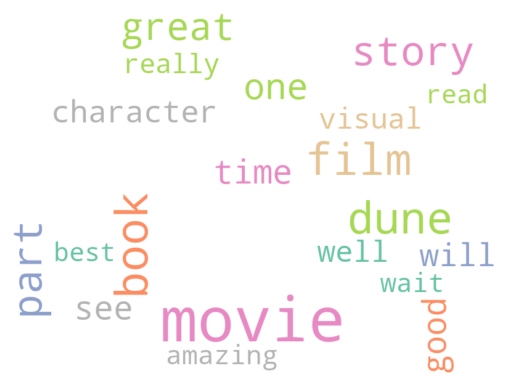

In [47]:
name = "dune_2021"

dune = pd.read_csv(data_path + name + ".csv")
plot_wordcloud(dune, name)

### Plot word frequency

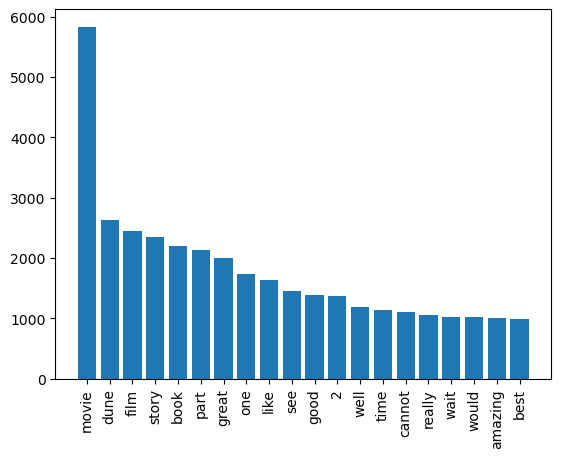

In [48]:
df_word_count = create_df_wordcount(dune)

# limit to the 20 most frequent words

df_pl = df_word_count.iloc[0:20, :]

plt.bar(x=df_pl["word"], height=df_pl["count"])
plt.xticks(rotation=90);

### Sentiment score

In [49]:
text = create_wordstring(dune)

print("AFINN:\t", afinn.score(text))
print("vader:\t", vader_sia.polarity_scores(text)["compound"])

AFINN:	 49101.0
vader:	 1.0


## Shining

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fstatic2.cbrimages.com%2Fwordpress%2Fwp-content%2Fuploads%2F2019%2F06%2Fshining-hallway-header.jpg&f=1&nofb=1&ipt=8a37a7bc3b1f5baa19ae3dd4327a6089fa016a2e5b3cf69d51d2035e50c2ac68&ipo=images" style="width:800px;"/>

### Word clouds

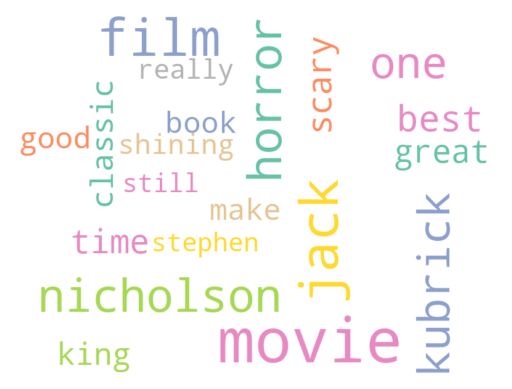

In [50]:
name = "shining"

shining = pd.read_csv(data_path + name + ".csv")
plot_wordcloud(shining, name)

### Plot word frequency

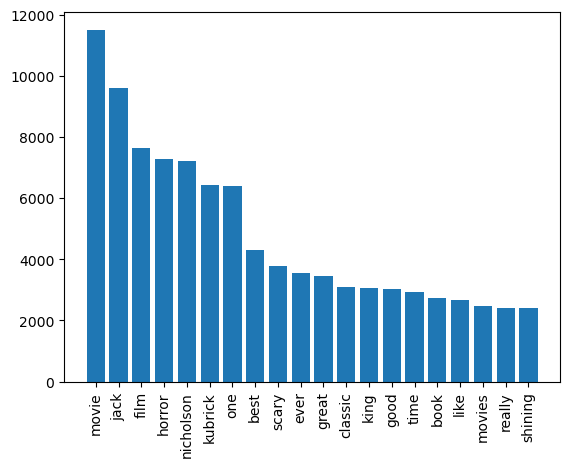

In [51]:
df_word_count = create_df_wordcount(shining)

# limit to the 20 most frequent words

df_pl = df_word_count.iloc[0:20, :]

plt.bar(x=df_pl["word"], height=df_pl["count"])
plt.xticks(rotation=90);

### Sentiment score

In [52]:
text = create_wordstring(shining)

print("AFINN:\t", afinn.score(text))
print("vader:\t", vader_sia.polarity_scores(text)["compound"])

AFINN:	 48539.0
vader:	 1.0
